In [5]:
import cv2
import numpy as np
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
from ultralytics import YOLO
import os

DEVICE = torch.device("cuda" if torch.cuda.is_available() else "cpu")


class ActivationAndGradientExtractor:
    """
    Utility class to register and store activations and gradients
    from a specific target layer using PyTorch hooks.
    """

    def __init__(self, target_layer):
        self.activations = None
        self.gradients = None
        target_layer.register_forward_hook(self._save_activation)
        target_layer.register_backward_hook(self._save_gradient)

    def _save_activation(self, module, input, output):
        """Captures the output of the target layer."""
        self.activations = output.detach()

    def _save_gradient(self, module, grad_input, grad_output):
        """Captures the gradient flowing back into the target layer."""
        # grad_output is a tuple, so we take the first element
        self.gradients = grad_output[0].detach()

    def clear(self):
        """Clears stored data to prepare for a new inference."""
        self.activations = None
        self.gradients = None

print(f"Target Device: {DEVICE}")

Target Device: cuda


In [7]:
def load_model_and_image():
    """Loads the YOLOv8 model and a test image, ensuring device consistency."""
    try:
        # Load the YOLO model and explicitly move it to the configured DEVICE
        model_yolo = YOLO("yolov8n.pt").to(DEVICE)
        print("YOLOv8n model loaded")

        # Get the internal PyTorch model and set it to evaluation mode
        model_pt = model_yolo.model.eval()

        image_path = "data/elephant.jpg"
        image = cv2.imread(image_path)
             
        if image is None:
            raise FileNotFoundError("Could not read image file.")

        return model_yolo, model_pt, image, image_path

    except Exception as e:
        print(f"Error during loading: {e}")
        return None, None, None, None


def get_target_layer(model_pt):
    """
    Identifies the target layer for Grad-CAM.
    """
    try:
        target_layer = model_pt.model[9] # model.model[9] is the last backbone block
        print(f"Grad-CAM target layer selected: {target_layer.__class__.__name__}")
        return target_layer
    except IndexError:
        print("Error: It couldn't find the target layer.")
        return None

model_yolo, model_pt, input_image, img_path = load_model_and_image()
target_layer = get_target_layer(model_pt)

if model_pt and target_layer:
    extractor = ActivationAndGradientExtractor(target_layer)
else:
    extractor = None

YOLOv8n model loaded
Grad-CAM target layer selected: SPPF


In [8]:
def generate_manual_gradcam(model_yolo, model_pt, image, extractor):
    """
    Calculates the Grad-CAM heatmap.
    
    Args:
        model_yolo: The Ultralytics YOLO object for detection inference.
        model_pt: The internal PyTorch model for the forward/backward pass.
        image: The input image (BGR format).
        extractor: The hook extractor object.
        
    Returns:
        The superimposed image (NumPy array) and the target class name.
    """
    if extractor is None:
        print("Extractor not initialized.")
        return None, None
    
    extractor.clear()
    
    # 1) Prepare Input Tensor (640x640 resize and normalization)
    img_resized = cv2.resize(image, (640, 640))
    rgb_img = cv2.cvtColor(img_resized, cv2.COLOR_BGR2RGB)
    
    input_tensor = torch.from_numpy(rgb_img).float()
    input_tensor = input_tensor.permute(2, 0, 1).unsqueeze(0).div(255.0)

    # Move tensor to device and enable gradient tracking
    input_tensor = input_tensor.to(DEVICE)
    input_tensor.requires_grad_(True)

    # 2) YOLO Detection (in order to identify the target box and score)
    results = model_yolo(cv2.cvtColor(image, cv2.COLOR_BGR2RGB), verbose=False)
    
    if len(results[0].boxes) == 0:
        print("\nThere is no object detected.")
        return None, None

    box_data = results[0].boxes[0]
    target_class_index = int(box_data.cls.cpu().item())
    target_class_name = results[0].names[target_class_index]

    print(f"Prediction: {target_class_name}")

    # 3) Forward Pass
    output = model_pt(input_tensor)

    try:
        target_score_tensor = output[0][0, 0, 4]
    except IndexError:
        print("Error: Could not index detection output (target_score_tensor).")
        return None, None
        
    

    # 4) Backward Pass
    model_pt.zero_grad()
    target_score_tensor.backward(retain_graph=True)

    # 5) Compute Weights (Global Average Pooling of Gradients)
    gradients = extractor.gradients
    activations = extractor.activations

    # GAP over gradients (spatial average: H and W)
    weights = torch.mean(gradients, dim=(2, 3), keepdim=True)

    # 6) Weighted Sum (Grad-CAM formula)
    weighted_activations = weights * activations
    cam = torch.sum(weighted_activations, dim=1).squeeze()

    # 7) Applying ReLU
    cam = F.relu(cam)

    # 8) Normalization and Resizing
    cam_numpy = cam.cpu().numpy()
    cam_numpy = cam_numpy / cam_numpy.max() 

    h, w, _ = image.shape
    cam_resized = cv2.resize(cam_numpy, (w, h))

    # 9) Superimposition and Bounding Box (Visualization)
    heatmap = cv2.applyColorMap(np.uint8(255 * cam_resized), cv2.COLORMAP_JET)

    original_rgb_img = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_img_float = original_rgb_img.astype(np.float32) / 255.0

    heatmap_rgb = cv2.cvtColor(heatmap, cv2.COLOR_BGR2RGB).astype(np.float32) / 255.0
    cam_image_superimposed = original_img_float * 0.7 + heatmap_rgb * 0.3
    cam_image_superimposed = (cam_image_superimposed * 255).astype(np.uint8)

    # 10) Adding bounding box
    x1, y1, x2, y2 = box_data.xyxy[0].cpu().numpy().astype(int)
    cv2.rectangle(cam_image_superimposed, (x1, y1), (x2, y2), (255, 0, 0), 2) # Red box
    cv2.putText(
        cam_image_superimposed,
        target_class_name,
        (x1, y1 - 10),
        cv2.FONT_HERSHEY_SIMPLEX,
        0.9,
        (255, 0, 0),
        2,
    )

    return cv2.cvtColor(cam_image_superimposed, cv2.COLOR_BGR2RGB), target_class_name

Prediction: elephant


c:\Users\LAY\AppData\Local\Programs\Python\Python313\Lib\site-packages\torch\nn\modules\module.py:1864: FutureWarning: Using a non-full backward hook when the forward contains multiple autograd Nodes is deprecated and will be removed in future versions. This hook will be missing some grad_input. Please use register_full_backward_hook to get the documented behavior.
  self._maybe_warn_non_full_backward_hook(args, result, grad_fn)


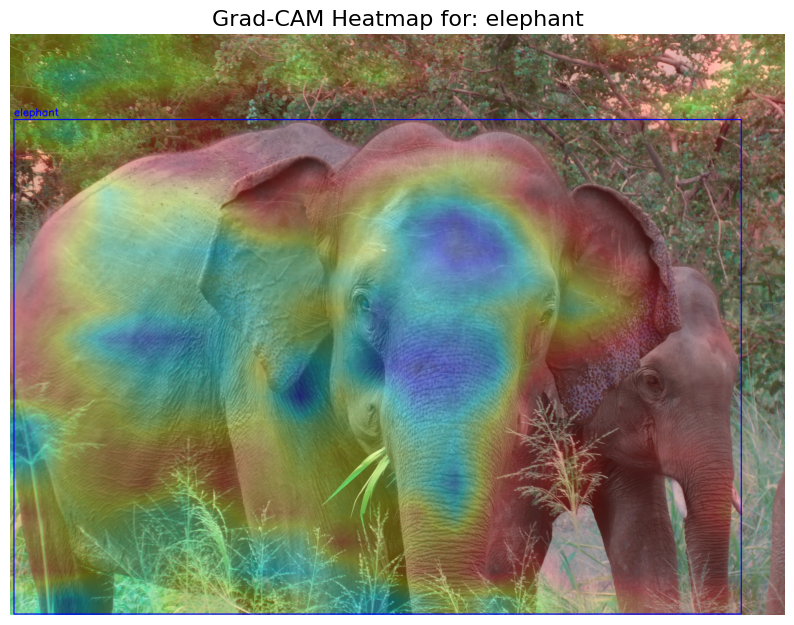

In [9]:
if model_pt and input_image is not None and extractor:
    grad_cam_image_rgb, target_name = generate_manual_gradcam(
        model_yolo, model_pt, input_image, extractor
    )

    if grad_cam_image_rgb is not None:
        plt.figure(figsize=(10, 10))
        plt.imshow(grad_cam_image_rgb)
        plt.title(f"Grad-CAM Heatmap for: {target_name}", fontsize=16)
        plt.axis("off")
        plt.show()
else:
    print(
        "\nThe cell execution requires a model and an image"
    )